## Project: Object Detection using YOLO-v3: 

The objective of this project is to demonstrate how to use the state of the art in object detection!
* It is not straight forward to reasonably train the YOLO-v3 network from scratch, due to several reasons including:
  * Lack of large volume of annotated data
  * Lack of sufficiently powerful computing resources
* Instead of exploring the training of YOLO-v3 from scratch we use an already trained model retrieved from the following source:

  * Trained YOLO-v3 model source: https://github.com/xiaochus/YOLOv3
  * Original YOLO-v3 paper: 
    * @article{YOLOv3, title={YOLOv3: An Incremental Improvement}, author={J Redmon, A Farhadi }, year={2018} 

  * This model has been trained on the COCO dataset:
    * Source: https://cocodataset.org/#home
    * COCO is a large-scale object detection, segmentation, and captioning dataset. 
    * 330K images (>200K labeled)
    * 80 object categories, including typical objects such as vehicles, people, cats, dogs, etc.
    
* In this work, we shall demonstrate how to deploy the trained model to detect objects of interest.

#### Author: Mohsen Ghazel (mghazel)
* Date: April 9th, 2021

### Step 1: Imports and global variables

#### 1.1) Python import:

In [37]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# opencv
import cv2
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#------------------------------------------------------
# Import the YOLO model from the downlaoded
# pretraiend model subfolder (model)
#------------------------------------------------------
from model.yolo_model import YOLO

# input/output OS
import os 

# date-time to show date and time
import datetime
# import time
import time

# to display the figures in the notebook
%matplotlib inline

#------------------------------------------
# Test imports and display package versions
#------------------------------------------
# Testing the OpenCV version
print("OpenCV : ",cv2.__version__)
# Testing the numpy version
print("Numpy : ",np.__version__)

OpenCV :  4.5.1
Numpy :  1.19.2


#### 1.2) Global variables:
* The YOLO model expects two parameters:
  * Confidence threshold: Only objects with detection confidence higher than this value are kept and the rest are discarded
  * NMS threshold: This is used by the NMS algorithm to combine overlapping detections

In [38]:
#------------------------------------------------------
# Confidence threshold: 
#------------------------------------------------------
# Only objects with detection confidence higher than this 
# value are kept and the rest are discarded
#------------------------------------------------------
DETECTION_CONFIDENCE_THRESHOLD = 0.50
#------------------------------------------------------
# NMS threshold: 
#------------------------------------------------------
# This is used by the NMS algorithm to combine overlapping 
# detections
#------------------------------------------------------
NMS_THRESHOLD = 0.50

### Step 2: Define untility functions:

#### 2.1)  A function pre-process images by resizing them as needed:

In [39]:
def process_image(img):
    """Resize, reduce and expand image.

    # Argument:
        img: original image.

    # Returns
        image: ndarray(64, 64, 3), processed image.
    """
    image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image /= 255.
    image = np.expand_dims(image, axis=0)

    return image

#### 2.2)  A function to get the class names:
* The YOLO-v3 model has been pre-trained on the COCO dataset, which has 80 classes
* This function retrieves the names of the 80 classes in the COCO data set by reading
  them from the configuration file


In [40]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

#### 2.3)  A visualization function:
* This function overlays the detection results on this image, including:
    * detection bounding-boxes
    * class name
    * detection confidence

In [41]:
def draw(image, boxes, scores, classes, all_classes):
    """Draw the boxes on the image.

    # Argument:
        image: original image.
        boxes: ndarray, boxes of objects.
        classes: ndarray, classes of objects.
        scores: ndarray, scores of objects.
        all_classes: all classes name.
    """
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 1,
                    cv2.LINE_AA)

        print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
        print('box coordinate x,y,w,h: {0}'.format(box))

    print()

#### 2.4) Inference function from an image:
* This function deploys the trained YOLO-v3 model to detect any potential objects of interest.

In [42]:
def detect_image(image, yolo, all_classes):
    """Use yolo v3 to detect images.

    # Argument:
        image: original image.
        yolo: YOLO, yolo model.
        all_classes: all classes name.

    # Returns:
        image: processed image.
    """
    pimage = process_image(image)

    start = time.time()
    boxes, classes, scores = yolo.predict(pimage, image.shape)
    end = time.time()

    print('time: {0:.2f}s'.format(end - start))

    if boxes is not None:
        draw(image, boxes, scores, classes, all_classes)

    return image

#### 2.5) Inference function from a video:
* This function deploys the trained YOLO-v3 model to detect any potential objects of interest
  from a video file
* Basically, each video frame is processes independently, using the previous function.

In [43]:
def detect_video(video, yolo, all_classes):
    """Use yolo v3 to detect video.

    # Argument:
        video: video file.
        yolo: YOLO, yolo model.
        all_classes: all classes name.
    """
    video_path = os.path.join("videos", "test", video)
    camera = cv2.VideoCapture(video_path)
    cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

    # Prepare for saving the detected video
    sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')

    
    vout = cv2.VideoWriter()
    vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

    while True:
        res, frame = camera.read()

        if not res:
            break

        image = detect_image(frame, yolo, all_classes)
        cv2.imshow("detection", image)

        # Save the video frame by frame
        vout.write(image)

        if cv2.waitKey(110) & 0xff == 27:
                break

    vout.release()
    camera.release()
    

### Step 3: Instantiate the YOLO-v3 model:

* We are now ready to instantiate the pre-trained YOLO-v3 model before it can be deployed:
* The YOLO model expects two paramaters:
    * Confidence threshold: Only objects with detection cinfidence higher than this 
        value are kept and the rest are discarded
    * NMS threshold: This is used by the NMS algorithm to combine overlapping detections

In [44]:
# Instantiate the YOLO model class
yolo = YOLO(DETECTION_CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
# this is the file containing the names of all the classes
file = 'data/coco_classes.txt'
# get all the names of the classes
all_classes = get_classes(file)

### Step 4: Deploy the trained YOLO-v3 model to detect objects of interest:

#### 4.1) Detection from images:
* First we can deploy it on individual input images to detect and localize potential objects of interest
* All test images in the test images folder will be processed
* We can get test images from open source site: 
  * Unsplash: https://unsplash.com/

time: 1.78s
class: dog, score: 0.99
box coordinate x,y,w,h: [ 10.19209296  14.36614296  86.29040748 132.3982138 ]
class: dog, score: 0.95
box coordinate x,y,w,h: [126.09061539   6.01810643  74.22350317 146.36979657]
class: dog, score: 0.56
box coordinate x,y,w,h: [81.35105833 62.04934654 61.20964855 82.47159237]
class: cat, score: 0.53
box coordinate x,y,w,h: [198.27343404  63.17662293  53.06311816  79.39320123]

time: 0.74s
class: person, score: 0.99
box coordinate x,y,w,h: [368.21359396 104.02029443 121.8848601  120.1177237 ]
class: person, score: 0.97
box coordinate x,y,w,h: [ 50.01873523 111.84529734 139.93528485 141.13240802]
class: person, score: 0.83
box coordinate x,y,w,h: [ 36.13579646  51.83125204  62.23230809 158.29805338]
class: person, score: 0.62
box coordinate x,y,w,h: [166.49897397  66.85848141  58.9142479  106.41536546]

time: 0.74s
class: person, score: 0.99
box coordinate x,y,w,h: [378.28749418 326.94270372 121.24058604 305.88562575]
class: person, score: 0.98
box co

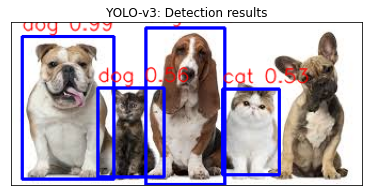

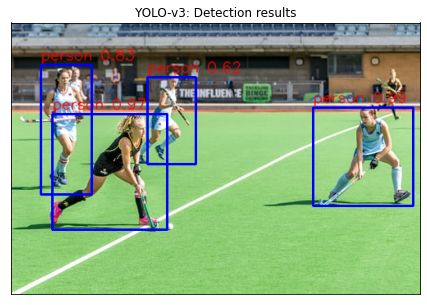

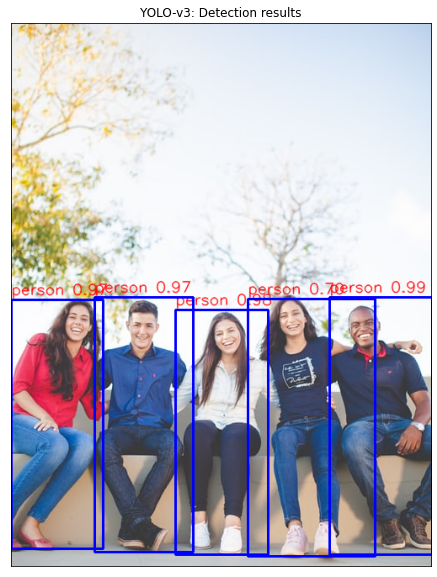

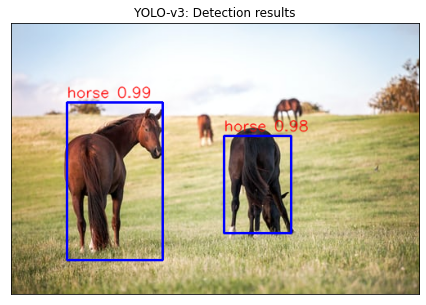

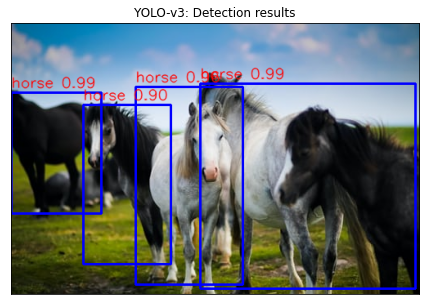

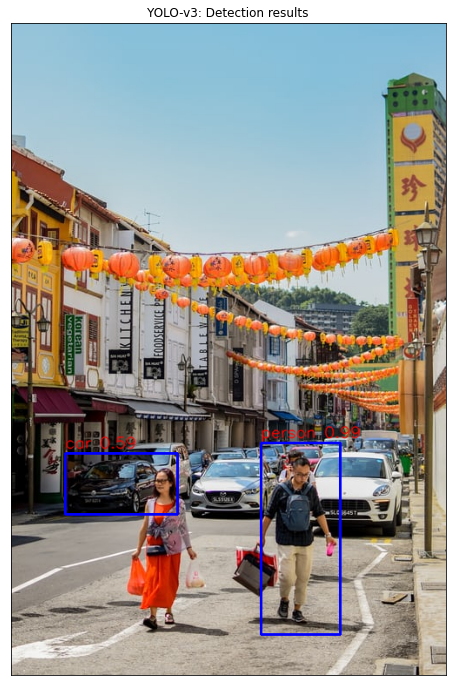

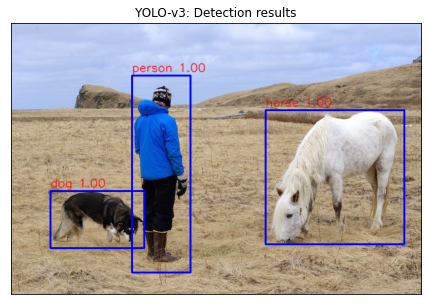

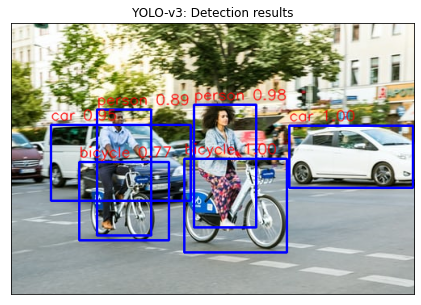

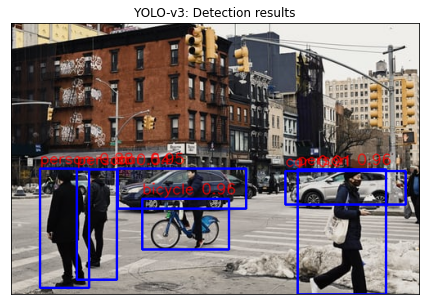

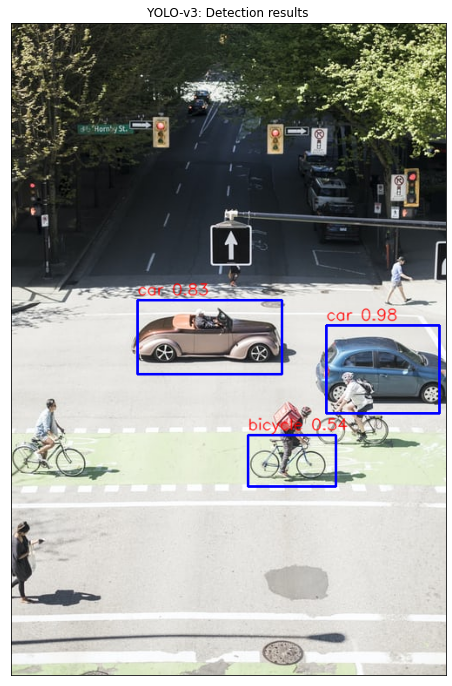

In [45]:
#------------------------------------------------------
# 4.1) Set test images folder name
#------------------------------------------------------
test_images_folder = 'images/test/'
#------------------------------------------------------
# 4.2) itetate over all the images in the test images 
#      folder
#------------------------------------------------------
for filename in os.listdir(test_images_folder):
    #------------------------------------------------------
    # 4.3) read the test image
    #------------------------------------------------------
    img = cv2.imread(os.path.join(test_images_folder,filename))
    if img is not None:
        #------------------------------------------------------
        # 4.4) deploy the YOLO model to conduct inference in 
        #      the image
        #------------------------------------------------------
        img = detect_image(img, yolo, all_classes)
        #------------------------------------------------------
        # 4.5) Visualize the detections results
        #------------------------------------------------------
        # create a figure
        plt.figure(figsize=(8, np.uint8(8 * img.shape[0]/img.shape[1])))
        # visualize detection results
        plt.subplot(111)
        plt.title("YOLO-v3: Detection results", fontsize=12)
        plt.xticks([]), plt.yticks([])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### 4.2) Detection from videos:
* We can deploy the trained YOLO-v3 model on a video to detect and localize potential objects of interest:
* Basically, each frame ofthe video is parsed and processed separately as an image, just like we illusrated above.

In [ ]:
#------------------------------------------------------
# detect videos one at a time in videos/test folder   
#------------------------------------------------------
# 4.2.1) Set test video folder and file name
#------------------------------------------------------
# test-video folder
test_video_folder = 'images/test/'
# test-video file name
test_video_fname = 'library1.mp4'
# test-video full-path file name
test_video_file_path = test_video_folder + test_video_fname 
#------------------------------------------------------
# 4.2.2) call detect_video() to conduct inference on 
#         the video
#------------------------------------------------------
detect_video(test_video_file_path, yolo, all_classes)

### Step 7: Display a successful execution message

In [36]:
# display a final message
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))

Program executed successfully on: 2021-04-14 21:39:22...Goodbye!

